# Week 8 Discussion Question: National Motor Vehicle Crash Causation Survey

## Load Packages

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import random as rnd

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Flatten, Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.regularizers import l1

## Import dataset

In [2]:
if not Path("NHTSA_NMVCCS_extract.parquet.gzip").exists():
    print("Downloading dataset")
    !wget https://github.com/JSchelldorfer/ActuarialDataScience/raw/master/12%20-%20NLP%20Using%20Transformers/NHTSA_NMVCCS_extract.parquet.gzip

df = pd.read_parquet("NHTSA_NMVCCS_extract.parquet.gzip")
print(f"shape of DataFrame: {df.shape}")

shape of DataFrame: (6949, 16)


## Data Cleaning

In [3]:
def lemmatize(txt):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(txt)
    goodTokens = [token.lemma_.lower() for token in doc \
        if not token.like_num and \
           not token.is_punct and \
           not token.is_space and \
           not token.is_currency and \
           not token.is_stop]
    return " ".join(goodTokens)

In [4]:
def splitDataset(lemma):
    weatherCols = [f"WEATHER{i}" for i in range(1, 9)]
    target = df["INJSEVB"]
    
    if lemma == True:
        df["SUMMARY_EN_LEMMA"] = df["SUMMARY_EN"].apply(lemmatize)
        weatherCols = [f"WEATHER{i}" for i in range(1, 9)]
        features = df[["SUMMARY_EN_LEMMA"] + weatherCols]
    else:
        features = df[["SUMMARY_EN"] + weatherCols]

    X_main, X_test, y_main, y_test = \
    train_test_split(features, target, test_size=0.2, random_state=1)

    # As 0.25 x 0.8 = 0.2
    X_train, X_val, y_train, y_val = \
    train_test_split(X_main, y_main, test_size=0.25, random_state=1)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
def vectorise_dataset(X, vect, txtCol="SUMMARY_EN", dataframe=False):
    X_vects = vect.transform(X[txtCol]).todense()
    X_other = X.drop(txtCol, axis=1)

    if not dataframe:
        return np.concatenate([X_vects, X_other], axis=1)
    else:
        # Add column names and indices to the combined dataframe.
        vocab = list(vect.get_feature_names_out())
        X_vects_df = pd.DataFrame(X_vects, columns=vocab, index=X.index)
        return pd.concat([X_vects_df, X_other], axis=1)

In [6]:
def processData(lemma, vectorizerType):
    
    # select text vectorizer
    if vectorizerType == "CountVectorizer":
        vectorizer = CountVectorizer
    elif vectorizerType == "TfidfVectorizer":
        vectorizer = TfidfVectorizer
    vect = vectorizer(max_features = 1_000, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', stop_words = "english")

    # apply the vectorizer to the training data
    if lemma == True:
        vect.fit(X_train["SUMMARY_EN_LEMMA"])
        X_train_ct = vectorise_dataset(X_train, vect, "SUMMARY_EN_LEMMA")
        X_val_ct = vectorise_dataset(X_val, vect, "SUMMARY_EN_LEMMA")
        X_test_ct = vectorise_dataset(X_test, vect, "SUMMARY_EN_LEMMA")
    else:
        vect.fit(X_train["SUMMARY_EN"])
        # transform the training, validation and test data
        X_train_ct = vectorise_dataset(X_train, vect)
        X_val_ct = vectorise_dataset(X_val, vect)
        X_test_ct = vectorise_dataset(X_test, vect)

    

    return X_train_ct, X_val_ct, X_test_ct, y_train, y_val, y_test, vect

## Model

In [7]:
def build_model(numFeatures):
    tf.random.set_seed(42)
    
    model = Sequential([
        Dense(1_000, input_dim=numFeatures, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer = "adam",
        loss="BinaryCrossentropy",
        metrics=["accuracy"])
    
    return model

## Count Vectorizer

Data processing

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = splitDataset(lemma=False)
X_train_ct, X_val_ct, X_test_ct, y_train, y_val, y_test, vect = processData(lemma=False, vectorizerType="CountVectorizer")

Define Model

In [9]:
numFeatures = X_train_ct.shape[1]
modelCV = build_model(numFeatures)
modelCV.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              1009000   
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1,010,001
Trainable params: 1,010,001
Non-trainable params: 0
_________________________________________________________________


Fit model

In [10]:
es = EarlyStopping(patience=1, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)
hist = modelCV.fit(X_train_ct, y_train, epochs=10, \
    callbacks=[es], validation_data=(X_val_ct, y_val), verbose=0);

Restoring model weights from the end of the best epoch: 2.
Epoch 3: early stopping


Model Assessment

In [11]:
train = modelCV.evaluate(X_train_ct, y_train, verbose=0)
val = modelCV.evaluate(X_val_ct, y_val, verbose=0)


In [12]:
bceTrain = {"CountVectorizer": train[0]}
bceVal = {"CountVectorizer": val[0]}

accuracyTrain = {"CountVectorizer": train[1]}
accuracyVal = {"CountVectorizer": val[1]}

## TfidfVectorizer

Data processing

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = splitDataset(lemma=False)
X_train_ct, X_val_ct, X_test_ct, y_train, y_val, y_test, vect = processData(lemma=False, vectorizerType="TfidfVectorizer")

Define model

In [14]:
numFeatures = X_train_ct.shape[1]
modelTF = build_model(numFeatures)
modelTF.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1000)              1009000   
                                                                 
 dense_3 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 1,010,001
Trainable params: 1,010,001
Non-trainable params: 0
_________________________________________________________________


Fit model

In [15]:
es = EarlyStopping(patience=1, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)
hist = modelTF.fit(X_train_ct, y_train, epochs=10, \
    callbacks=[es], validation_data=(X_val_ct, y_val), verbose=0);

Restoring model weights from the end of the best epoch: 3.
Epoch 4: early stopping


Model Assessment

In [16]:
train = modelTF.evaluate(X_train_ct, y_train, verbose=0)
val = modelTF.evaluate(X_val_ct, y_val, verbose=0)

In [17]:
bceTrain["TfidfVectorizer"] = train[0]
bceVal["TfidfVectorizer"] = val[0]
accuracyTrain["TfidfVectorizer"] = train[1]
accuracyVal["TfidfVectorizer"] = val[1]

## Best Model

Select model with highest val accuracy

In [18]:
bceTrainResults = pd.DataFrame({
    "Model": bceTrain.keys(), "BinaryCrossEntropy": bceTrain.values()
})
bceTrainResults.sort_values("BinaryCrossEntropy", ascending=False)

,Model,BinaryCrossEntropy
1,TfidfVectorizer,0.153816
0,CountVectorizer,0.106384


In [19]:
bceValResults= pd.DataFrame({
    "Model": bceVal.keys(), "BinaryCrossEntropy": bceVal.values()
})
bceValResults.sort_values("BinaryCrossEntropy", ascending=False)

,Model,BinaryCrossEntropy
1,TfidfVectorizer,93.190964
0,CountVectorizer,10.047592


In [27]:
accuracyTrainResults= pd.DataFrame({
    "Model": accuracyTrain.keys(), "Accuracy":accuracyTrain.values()
})
accuracyTrainResults.sort_values("Accuracy", ascending=False)

,Model,Accuracy
0,CountVectorizer,0.969537
1,TfidfVectorizer,0.950828


In [28]:
accuracyValResults= pd.DataFrame({
    "Model": accuracyVal.keys(), "Accuracy":accuracyVal.values()
})
accuracyValResults.sort_values("Accuracy", ascending=False)

,Model,Accuracy
0,CountVectorizer,0.892086
1,TfidfVectorizer,0.889209


Fit model to test data

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = splitDataset(lemma=False)
X_train_ct, X_val_ct, X_test_ct, y_train, y_val, y_test, vect = processData(lemma=False, vectorizerType="CountVectorizer")
modelCV.evaluate(X_test_ct, y_test, verbose=0)

[0.29040345549583435, 0.8892086148262024]

Permutation test

In [23]:
def permutation_test(model, X, y, numReps=1, seed=42):
    """
    Run the permutation test for variable importance.
    Returns matrix of shape (X.shape[1], len(model.evaluate(X, y))).
    """
    rnd.seed(seed)
    scores = []    

    for j in range(X.shape[1]):
        originalColumn = np.copy(X[:, j])
        colScores = []

        for r in range(numReps):
            rnd.shuffle(X[:,j])
            colScores.append(model.evaluate(X, y, verbose=0))

        scores.append(np.mean(colScores, axis=0))
        X[:,j] = originalColumn
    
    return np.array(scores)

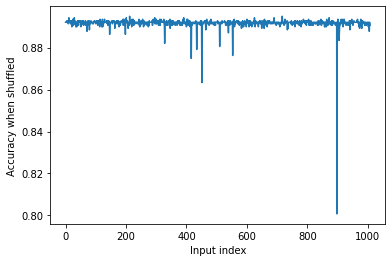

In [24]:
permScores = permutation_test(modelCV, X_val_ct, y_val)[:,1]
plt.plot(permScores);
plt.xlabel("Input index"); plt.ylabel("Accuracy when shuffled");

In [26]:
inputCols = \
    vectorise_dataset(X_train, vect, "SUMMARY_EN", True).columns
bestInputInds = np.argsort(permScores)[:50]
bestInputs = list(inputCols[bestInputInds])
print(bestInputs)

['transported', 'injuries', 'hospital', 'minor', 'incapacitating', 'local', 'facility', 'trauma', 'treated', 'critical', 'coded', 'medical', 'treatment', 'WEATHER6', 'barrier', 'belted', 'roads', 'intersection', 'v2', 'traveling', 'curve', 'feet', 'conditions', 'weekday', 'possible', 'point', 'wet', 'roadway', 'non', 'injury', 'performance', 'median', 'associated', 'drives', 'turning', 'related', 'super', 'suffered', 'continued', 'direction', 'suddenly', 'north', 'facing', 'moderate', 'scene', 'located', 'noted', 'cause', 'heading', 'passenger']
